# 1. Imports, Options and Ingestion

In [12]:
# Imports list
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score

from minisom import MiniSom

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

from sklearn.impute import KNNImputer
from sklearn.metrics import root_mean_squared_error

In [13]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [14]:
path = '/home/shadybea/OneDrive/General/Data Mining/Project/'

In [15]:
# Reading the csv data
data = pd.read_csv(f'{path}all_customers_preproc.csv', index_col=0)

regulars = pd.read_csv(f'{path}regulars_preproc.csv', index_col=0)

# 2. RFM

In [16]:
rfm_df = data.copy()

In [17]:
rfm_df['recency'] = 90 - rfm_df['last_order']

In [18]:
rfm_df = rfm_df[['recency', 'n_order', 'total_amt']]

In [19]:
# Get the values for R, F and M
rfm_df['r_value'] = pd.qcut(rfm_df['recency'], 3, labels=[1, 2, 3])
rfm_df['f_value'] = pd.qcut(rfm_df['n_order'], 3, labels=[1, 2, 3])
rfm_df['m_value'] = pd.qcut(rfm_df['total_amt'], 3, labels=[1, 2, 3])

In [20]:
rfm_df['rfm_score'] = rfm_df['r_value'].astype('str') + rfm_df['f_value'].astype('str') + rfm_df['m_value'].astype('str')

In [21]:
# Scaling the data
rfm_scaler = StandardScaler().set_output(transform='pandas')
rfm_scaled_ = pd.concat([
    rfm_scaler.fit_transform(rfm_df.drop(columns=['r_value', 'f_value', 'm_value', 'rfm_score']))
    ,rfm_df[['r_value', 'f_value', 'm_value', 'rfm_score']]
], axis=1)

In [22]:
rfm_features = ['recency', 'n_order', 'total_amt']

In [23]:
# Creating the dataframe with only the needed features
rfm_scaled = rfm_scaled_[rfm_features]

## R, F & M Clustering

In [24]:
# Function to calculate R² for a clustering solution
def get_rsq(df, features, label_column):
    """Calculates R² for a clustering solution.
    
    R² = SSb / SSt
    where:
    SSb = between-group sum of squares
    SSt = total sum of squares
    
    Parameters:
    df (DataFrame): The dataframe containing the features and cluster labels
    features (list): List of feature columns to consider
    label_column (str): The column containing the cluster labels
    
    Returns:
    float: R² value indicating homogeneity of the clusters
    """
    # Total Sum of Squares (SSt)
    mean = df[features].mean().values
    sst = np.sum((df[features].values - mean) ** 2)

    # Between-group Sum of Squares (SSb)
    ssb = 0
    for label in df[label_column].unique():
        group = df[df[label_column] == label]
        group_mean = group[features].mean().values
        ssb += len(group) * np.sum((group_mean - mean) ** 2)
        
    # R² Calculation
    r2 = ssb / sst if sst != 0 else 0
    return r2

In [25]:
# # Running R² Calculation for Different Hierarchical Clustering Methods
# hc_methods = ["ward", "complete", "average", "single"]
# max_nclus = 8

# # Initialize an empty list to store R² values for each method
# r2_hc = []

# # Compute R² for each clustering method and range of clusters
# for link in hc_methods:
#     print(link)
#     r2_method = []
#     for i in range(1, max_nclus + 1):  # Loop over cluster counts
#         print(i)
#         cluster = AgglomerativeClustering(n_clusters=i, metric="euclidean", linkage=link)
        
#         # Get cluster labels
#         hclabels = cluster.fit_predict(rfm_scaled)
        
#         # Concatenate the df with the cluster labels
#         df_concat = pd.concat([rfm_scaled, pd.Series(hclabels, name='labels', index=rfm_scaled.index)], axis=1)  
        
#         # Compute R² for the current number of clusters
#         r2_method.append(get_rsq(df_concat, rfm_scaled.columns.tolist(), 'labels'))
    
#     r2_hc.append(r2_method)

# # Convert R² results into a numpy array for easier manipulation
# r2_hc = np.vstack(r2_hc)

In [26]:
# # Plotting the R² values for Hierarchical Clustering Methods
# sns.set()

# # Create a figure for the plot
# fig = plt.figure(figsize=(11, 5))

# # Plot the R² values for each clustering method
# for i, link in enumerate(hc_methods):
#     sns.lineplot(data=r2_hc[i], linewidth=2.5, markers=["o"] * max_nclus, label=link)

# # Finalize the plot
# plt.legend(title="HC Methods", title_fontsize=11)
# plt.xticks(range(1, max_nclus + 1))
# plt.xlabel("Number of Clusters", fontsize=13)
# plt.ylabel("R² Metric", fontsize=13)
# fig.suptitle("$R^2$ Plot for Various Hierarchical Methods", fontsize=21)

# plt.show()

In [27]:
# # Plotting the Dendrogram for Hierarchical Clustering
# # Using the 'ward' method for dendrogram plotting (you can adjust this method)
# linkage_matrix = linkage(rfm_scaled.values, method="ward", metric="euclidean")

# sns.set()
# fig = plt.figure(figsize=(11, 5))
# # Set a threshold for cutting the dendrogram
# y_threshold = 100
# dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
# plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
# plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21)
# plt.xlabel('Number of Points in Node')
# plt.ylabel(f'Euclidean Distance', fontsize=13)
# plt.show()

In [28]:
avg_silhouette = []
for nclus in range(1, 9):
    # Skip nclus == 1
    if nclus == 1:
        continue

    cluster = AgglomerativeClustering(n_clusters=nclus, metric="euclidean", linkage="ward") # Example params
    hc_labels = cluster.fit_predict(rfm_scaled)

    # Calculate centroids based on these hierarchical clusters
    centroids = []
    for i in range(nclus):
        cluster_points = rfm_scaled[hc_labels == i]  # Get points belonging to cluster i
        centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
        centroids.append(centroid)

    centroids = np.array(centroids)

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init=centroids, n_init=1, random_state=20)
    cluster_labels = kmclust.fit_predict(rfm_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 2, the average silhouette_score is : 0.5066103393892333
For n_clusters = 3, the average silhouette_score is : 0.43428645964272694
For n_clusters = 4, the average silhouette_score is : 0.415754065562995
For n_clusters = 5, the average silhouette_score is : 0.34292603967734375
For n_clusters = 6, the average silhouette_score is : 0.34430832386523513
For n_clusters = 7, the average silhouette_score is : 0.34618731588107055
For n_clusters = 8, the average silhouette_score is : 0.3384279878299234


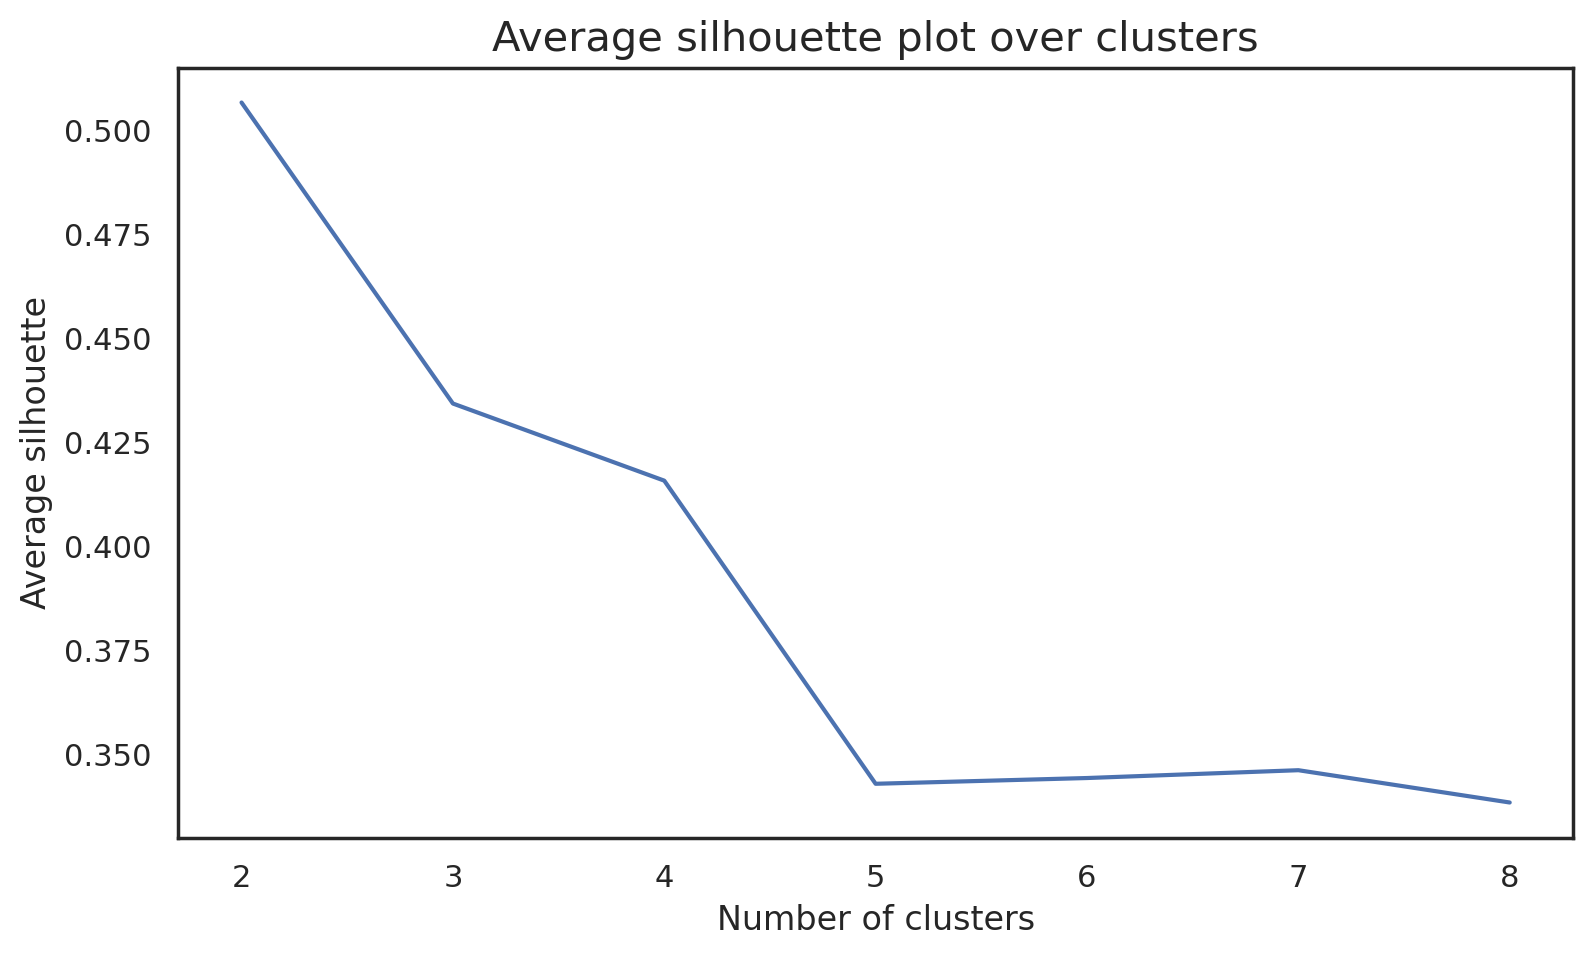

In [29]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range(2, 9), ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [30]:
n_clusters = 4

cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward") # Example params
hc_labels = cluster.fit_predict(rfm_scaled)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(nclus):
    cluster_points = rfm_scaled[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)


centroids = np.array(centroids)[:n_clusters]

In [31]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(rfm_scaled)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(rfm_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.415754065562995


In [32]:
df_rfm_concat = pd.concat([
    rfm_scaled, 
    pd.Series(hc_labels, name='labels', index=rfm_scaled.index)
    ], 
    axis=1)
df_rfm_concat.groupby('labels').median()

,recency,n_order,total_amt
labels,,,
0,-0.474131,-0.298879,-0.321598
1,-0.825338,1.120550,1.009184
2,1.457502,-0.535451,-0.618381
3,-0.957040,3.249695,2.284796


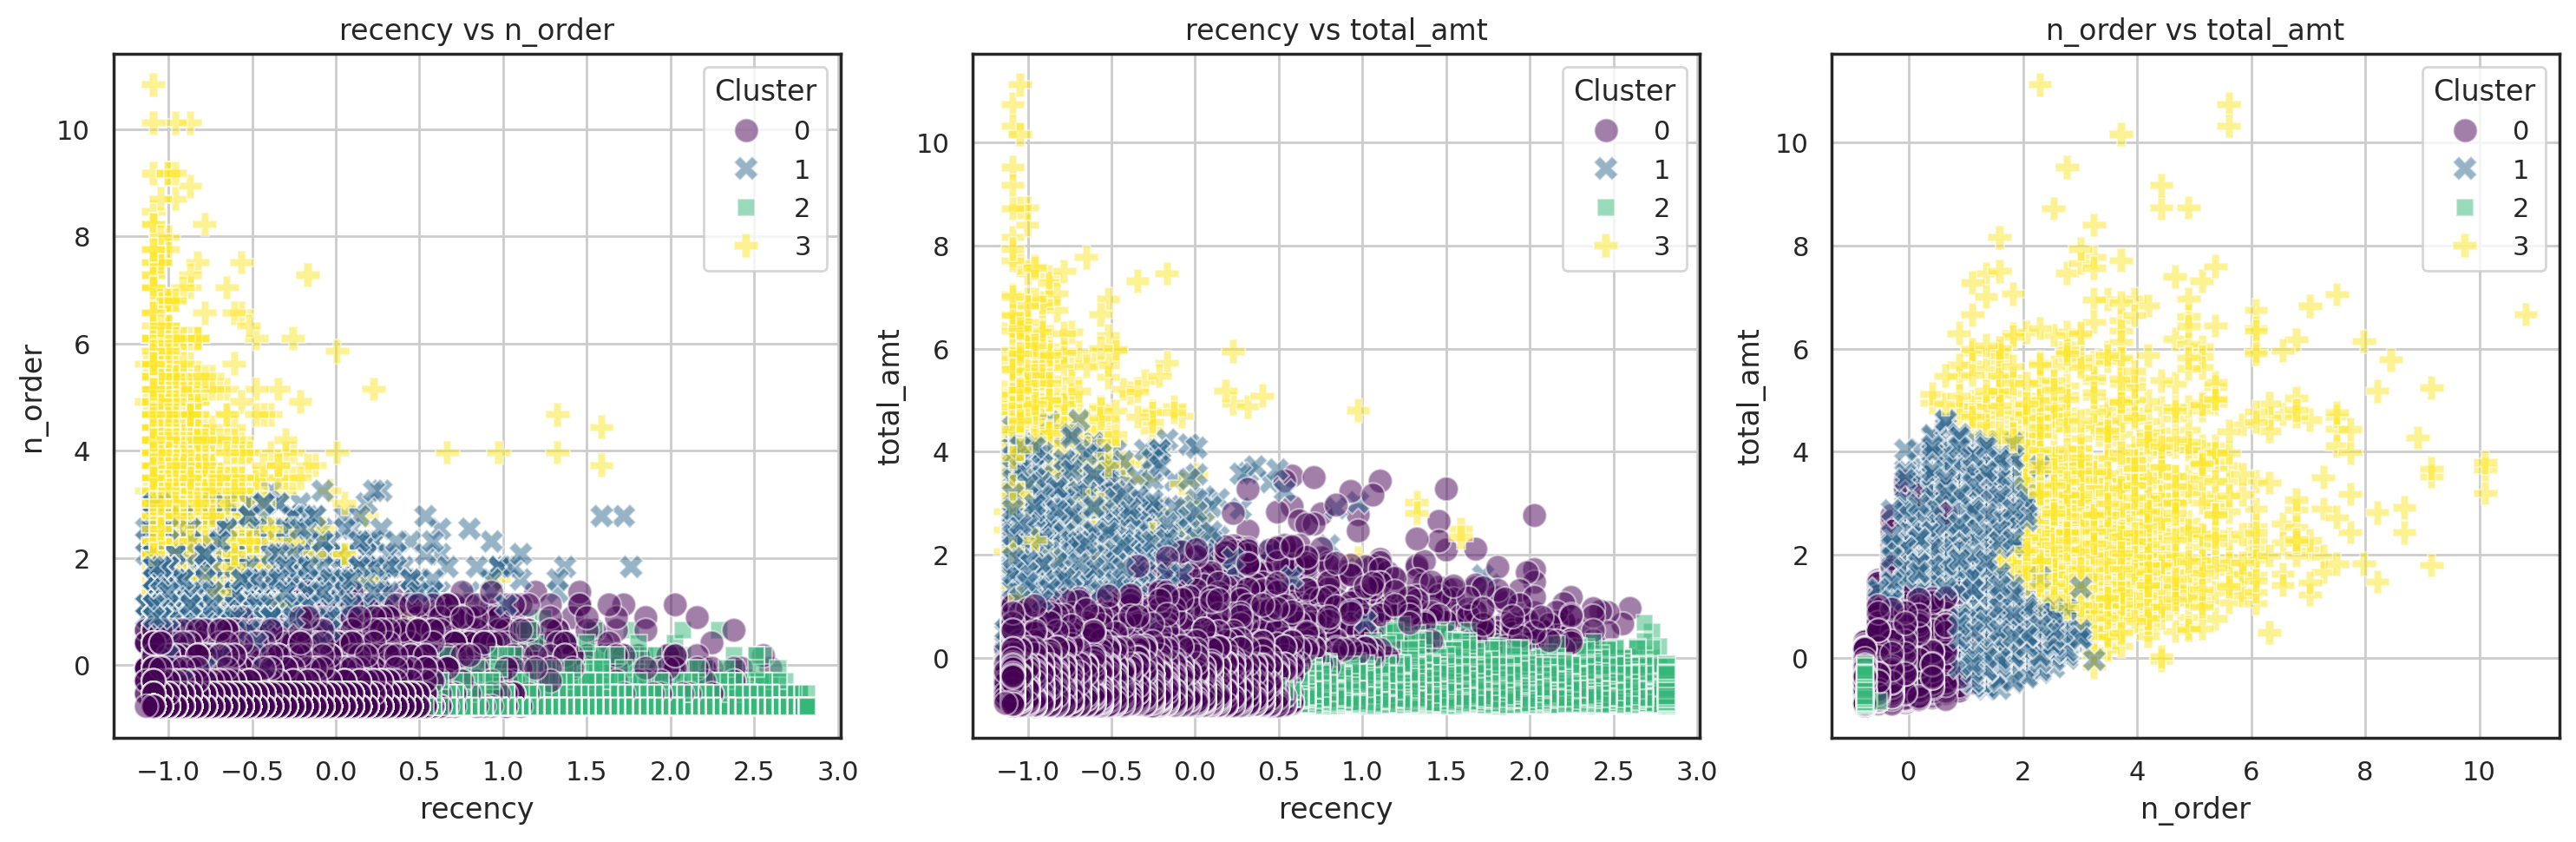

In [33]:
import itertools


combinations = list(itertools.combinations(df_rfm_concat.columns[:-1], 2))
n_combinations = len(combinations)

# Step 3: Set up subplots
n_cols = 3  # Number of columns in the grid
n_rows = (n_combinations + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Step 4: Plot each combination
for ax, (feature_x, feature_y) in zip(axes.flatten(), combinations):
    sns.scatterplot(
        data=df_rfm_concat,
        x=feature_x,
        y=feature_y,
        hue='labels',  # Cluster labels
        palette='viridis',
        style='labels',  # Optional: use style for labels too
        s=100,  # Point size
        alpha=0.5,  # Transparency
        ax=ax
    )
    ax.set_title(f"{feature_x} vs {feature_y}")
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(title="Cluster", loc='best')
    ax.grid(True)

# Remove any empty subplots
for i in range(n_combinations, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Step 5: Adjust layout
plt.tight_layout()
plt.show()

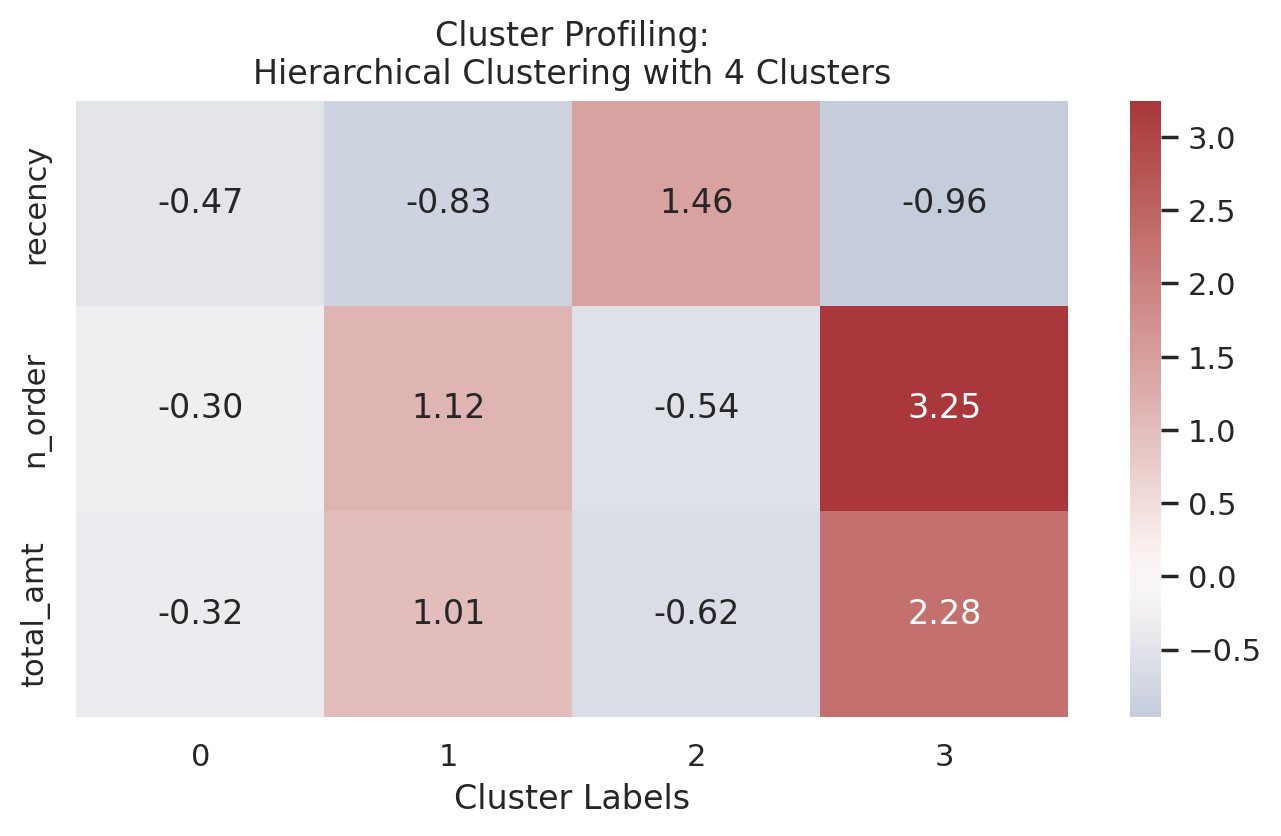

In [34]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_rfm_concat.groupby('labels').median().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="vlag", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nHierarchical Clustering with {n_clusters} Clusters")
plt.show()

### Profiling

In [37]:
rfm_profiling = pd.merge(
    df_rfm_concat
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [38]:
profiling = {
    'Promotion': [col for col in rfm_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in rfm_profiling.columns if col.startswith('pay_method_')]
    ,'City': [col for col in rfm_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in rfm_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in rfm_profiling.columns if col.startswith('age_bucket_')]
}

In [39]:
for profile, cols in profiling.items():
    cluster_profile = rfm_profiling.groupby('labels')[cols].mean().reset_index()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


,labels,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO_PROMO
0,0,0.148969,0.129621,0.144371,0.577039
1,1,0.104862,0.112771,0.130639,0.651728
2,2,0.197843,0.145455,0.135593,0.521109
3,3,0.096948,0.114004,0.122980,0.666068


Cluster Profiling Based on Payment Method


,labels,pay_method_CARD,pay_method_CASH,pay_method_DIGI
0,0,0.701679,0.131409,0.166911
1,1,0.743702,0.105448,0.150849
2,2,0.628043,0.170416,0.201541
3,3,0.754937,0.119390,0.125673


Cluster Profiling Based on City


,labels,cust_city_2.0,cust_city_4.0,cust_city_8.0
0,0,0.325522,0.340591,0.333887
1,1,0.380785,0.269186,0.350029
2,2,0.462250,0.281356,0.256394
3,3,0.362657,0.412029,0.225314


Cluster Profiling Based on Region


,labels,cust_region_2360.0,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0
0,0,0.266586,0.058936,0.027137,0.313454,0.013920,0.000319,0.319648
1,1,0.305507,0.075278,0.013181,0.256005,0.010545,0.000293,0.339192
2,2,0.385824,0.076425,0.024961,0.256394,0.009861,0.000000,0.246533
3,3,0.311490,0.051167,0.014363,0.397666,0.003591,0.000000,0.221724


Cluster Profiling Based on Age


,labels,age_bucket_15-24,age_bucket_25-34,age_bucket_35-44,age_bucket_45-54,age_bucket_55-64,age_bucket_65+
0,0,0.387523,0.474874,0.108358,0.023881,0.003767,0.001596
1,1,0.384886,0.479496,0.108670,0.021968,0.003808,0.001172
2,2,0.391680,0.468413,0.112481,0.020955,0.005239,0.001233
3,3,0.377917,0.483842,0.105925,0.023339,0.006284,0.002693


## Spending Diversity Clustering

In [40]:
spending_diversity = ['total_amt', 'n_cuisines', 'n_vendor', 'n_product']

In [41]:
# Creating the dataframe with the needed features
spending_diversity_df = regulars[spending_diversity]

In [42]:
n_clusters = 6

# Get the labels from hierarchical chosen clustering solution
cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
hc_labels = cluster.fit_predict(spending_diversity_df)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(n_clusters):
    cluster_points = spending_diversity_df[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)

centroids = np.array(centroids)

In [43]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(spending_diversity_df)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(spending_diversity_df, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3869080522878804


In [44]:
df_sd_concat = pd.concat([
    spending_diversity_df, 
    pd.Series(hc_labels, name='labels', index=spending_diversity_df.index)
    ], 
    axis=1)

In [45]:
df_sd_concat.groupby('labels').median()

,total_amt,n_cuisines,n_vendor,n_product
labels,,,,
0,1.783170,2.308388,2.793787,2.999063
1,-0.573333,-0.438966,-0.629457,-0.604493
2,0.488114,-0.438966,-0.249096,0.081899
3,-0.024137,1.621549,1.272345,0.768290
4,1.554660,0.934711,0.891985,0.939888
5,-0.471579,0.247872,-0.249096,-0.261297


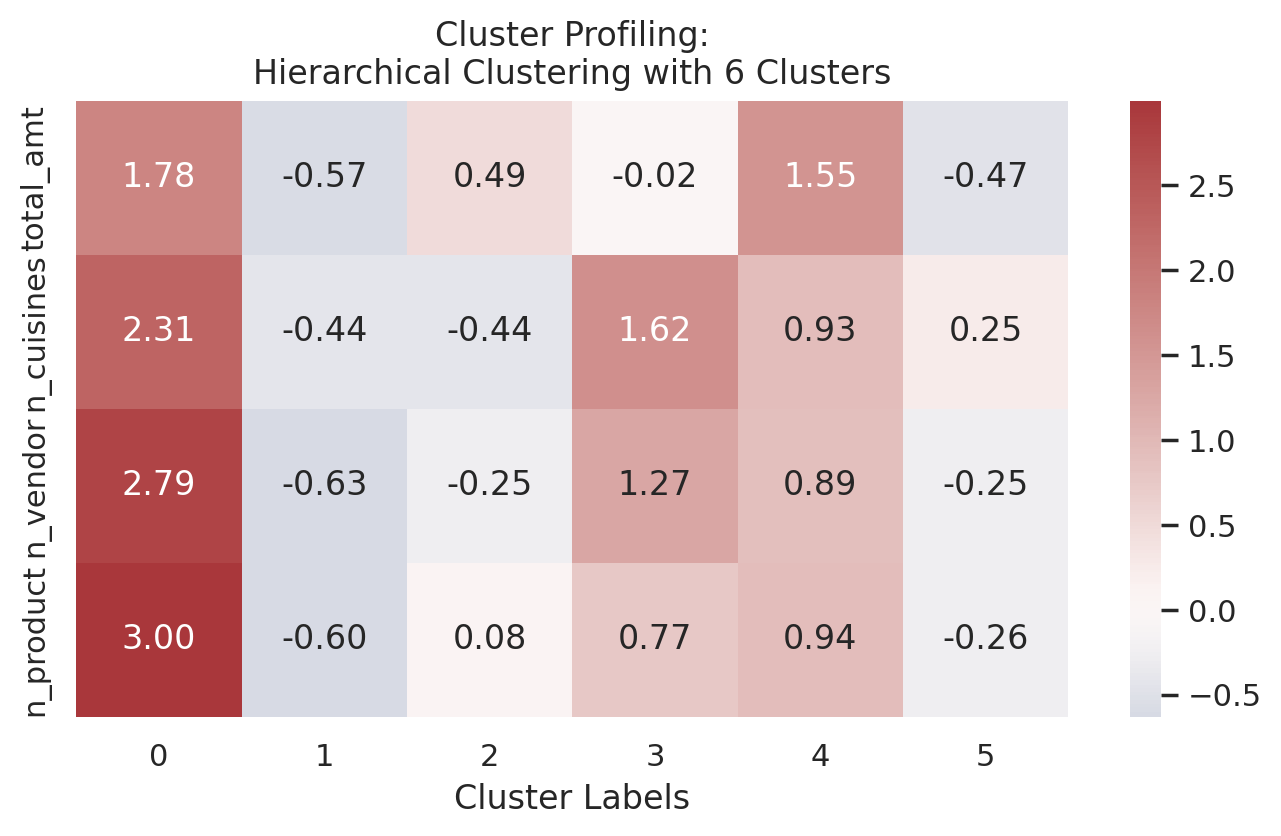

In [46]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_sd_concat.groupby('labels').median().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="vlag", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nHierarchical Clustering with {n_clusters} Clusters")
plt.show()

### Profiling

In [47]:
spending_diversity_profiling = pd.merge(
    df_sd_concat
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [48]:
profiling = {
    'Promotion': [col for col in spending_diversity_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in spending_diversity_profiling.columns if col.startswith('pay_method_')]
    ,'City': [col for col in spending_diversity_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in spending_diversity_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in spending_diversity_profiling.columns if col.startswith('age_bucket_')]
}

In [49]:
for profile, cols in profiling.items():
    cluster_profile = spending_diversity_profiling.groupby('labels')[cols].mean().reset_index()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


,labels,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO_PROMO
0,0,0.110112,0.128090,0.120225,0.641573
1,1,0.172876,0.139015,0.143280,0.544829
2,2,0.104218,0.091501,0.137407,0.666873
3,3,0.134014,0.150841,0.131611,0.583534
4,4,0.096417,0.090095,0.132771,0.680717
5,5,0.144028,0.137237,0.144496,0.574239


Cluster Profiling Based on Payment Method


,labels,pay_method_CARD,pay_method_CASH,pay_method_DIGI
0,0,0.764045,0.113483,0.122472
1,1,0.669046,0.147371,0.183583
2,2,0.769851,0.101427,0.128722
3,3,0.730168,0.105769,0.164062
4,4,0.746575,0.113277,0.140148
5,5,0.685480,0.138642,0.175878


Cluster Profiling Based on City


,labels,cust_city_2.0,cust_city_4.0,cust_city_8.0
0,0,0.552809,0.248315,0.198876
1,1,0.317897,0.358896,0.323207
2,2,0.076923,0.360112,0.562965
3,3,0.837139,0.125601,0.037260
4,4,0.022655,0.417808,0.559536
5,5,0.579391,0.261827,0.158782


Cluster Profiling Based on Region


,labels,cust_region_2360.0,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0
0,0,0.470787,0.082022,0.004494,0.243820,0.002247,0.000000,0.196629
1,1,0.262448,0.055449,0.035776,0.323120,0.015233,0.000261,0.307712
2,2,0.063586,0.013337,0.024814,0.335298,0.020471,0.000931,0.541563
3,3,0.675481,0.161659,0.000601,0.125000,0.001202,0.000000,0.036058
4,4,0.016860,0.005796,0.014752,0.403056,0.015279,0.000000,0.544257
5,5,0.473536,0.105855,0.010070,0.251756,0.003747,0.000000,0.155035


Cluster Profiling Based on Age


,labels,age_bucket_15-24,age_bucket_25-34,age_bucket_35-44,age_bucket_45-54,age_bucket_55-64,age_bucket_65+
0,0,0.377528,0.491011,0.098876,0.022472,0.007865,0.002247
1,1,0.391017,0.472580,0.108113,0.023329,0.003482,0.001480
2,2,0.378722,0.478288,0.112283,0.023573,0.004653,0.002481
3,3,0.388221,0.472356,0.112981,0.022236,0.003606,0.000601
4,4,0.384089,0.477345,0.111697,0.024236,0.001581,0.001054
5,5,0.386651,0.476112,0.107494,0.022482,0.005855,0.001405


## Head to Head

In [50]:
df_final_concat = pd.concat([
    df_rfm_concat.rename(columns={'labels': 'rfm_labels'})
    ,df_sd_concat.rename(columns={'labels': 'spending_labels'})
], axis=1)

In [51]:
df_final_concat.dropna(subset=['spending_labels'], inplace=True)

In [52]:
df_final_concat.head()

,recency,n_order,total_amt,rfm_labels,total_amt,n_cuisines,n_vendor,n_product,spending_labels
customer_id,,,,,,,,,
103287041752,2.730624,-0.535451,-0.123567,2,-0.271679,-0.438966,-0.629457,-0.604493,1.0
338018592517,2.730624,-0.535451,0.505285,2,0.322422,-0.438966,-0.629457,-0.261297,2.0
459279132454,2.730624,-0.535451,-0.298424,2,-0.436874,-1.125804,-0.629457,-0.776091,1.0
568914241263,2.730624,-0.535451,-0.759530,2,-0.872498,-0.438966,-0.629457,-0.776091,1.0
1043496422503,2.730624,-0.535451,-0.003748,2,-0.158482,-0.438966,-0.629457,-0.604493,1.0


### RFM vs Spending

In [53]:
rfm_spending_prop = pd.DataFrame(
    df_final_concat.groupby(['rfm_labels', 'spending_labels']).size()  / df_final_concat.shape[0]
).reset_index()

In [54]:
rfm_spending_prop.rename(columns={0: 'Total Proportion'}, inplace=True)

In [55]:
rfm_spending_prop['Proportion_within_rfm_labels'] = rfm_spending_prop.groupby('rfm_labels')['Total Proportion'].transform(lambda x: x / x.sum())

In [56]:
rfm_spending_prop

,rfm_labels,spending_labels,Total Proportion,Proportion_within_rfm_labels
0,0,0.0,0.000043,0.000064
1,0,1.0,0.373901,0.559479
2,0,2.0,0.100154,0.149863
3,0,3.0,0.025903,0.038759
4,0,4.0,0.011735,0.017560
5,0,5.0,0.156567,0.234276
6,1,0.0,0.007297,0.050088
7,1,1.0,0.000939,0.006444
8,1,2.0,0.034266,0.235208
9,1,3.0,0.043911,0.301406


### Spending vs RFM

In [57]:
spending_rfm_prop = pd.DataFrame(
    df_final_concat.groupby(['spending_labels', 'rfm_labels']).size() / df_final_concat.shape[0]
).reset_index()

In [58]:
spending_rfm_prop.rename(columns={0: 'Total Proportion'}, inplace=True)

In [59]:
spending_rfm_prop['Proportion_within_spending_labels'] = spending_rfm_prop.groupby('spending_labels')['Total Proportion'].transform(lambda x: x / x.sum())

In [60]:
spending_rfm_prop

,spending_labels,rfm_labels,Total Proportion,Proportion_within_spending_labels
0,0.0,0,0.000043,0.001124
1,0.0,1,0.007297,0.192135
2,0.0,3,0.030639,0.806742
3,1.0,0,0.373901,0.762709
4,1.0,1,0.000939,0.001915
5,1.0,2,0.115388,0.235376
6,2.0,0,0.100154,0.727978
7,2.0,1,0.034266,0.249069
8,2.0,2,0.000811,0.005893
9,2.0,3,0.002347,0.017060


### Removing Customers

In [61]:
customers = df_final_concat[
    (
        (df_final_concat['rfm_labels'] == 0) & (df_final_concat['spending_labels'] == 3)
    )
].index

In [62]:
len(customers)

607

In [63]:
spending_diversity_after_df = spending_diversity_df.drop(index=customers)

In [64]:
# Rescaling the data
after_scaler = StandardScaler().set_output(transform='pandas')
spending_diversity_after_df = after_scaler.fit_transform(spending_diversity_after_df)

## New Spending Diversity Clustering

In [65]:
avg_silhouette = []
for nclus in range(3, 9):
    # Skip nclus == 1
    if nclus == 1:
        continue

    cluster = AgglomerativeClustering(n_clusters=nclus, metric="euclidean", linkage="ward") # Example params
    hc_labels = cluster.fit_predict(spending_diversity_after_df)

    # Calculate centroids based on these hierarchical clusters
    centroids = []
    for i in range(nclus):
        cluster_points = spending_diversity_after_df[hc_labels == i]  # Get points belonging to cluster i
        centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
        centroids.append(centroid)

    centroids = np.array(centroids)

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init=centroids, n_init=1, random_state=20)
    cluster_labels = kmclust.fit_predict(spending_diversity_after_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(spending_diversity_after_df, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

For n_clusters = 3, the average silhouette_score is : 0.4703027026166065
For n_clusters = 4, the average silhouette_score is : 0.3692473933780356
For n_clusters = 5, the average silhouette_score is : 0.3842141836130506
For n_clusters = 6, the average silhouette_score is : 0.3890363633895125
For n_clusters = 7, the average silhouette_score is : 0.38337869321197543
For n_clusters = 8, the average silhouette_score is : 0.33885602176257457


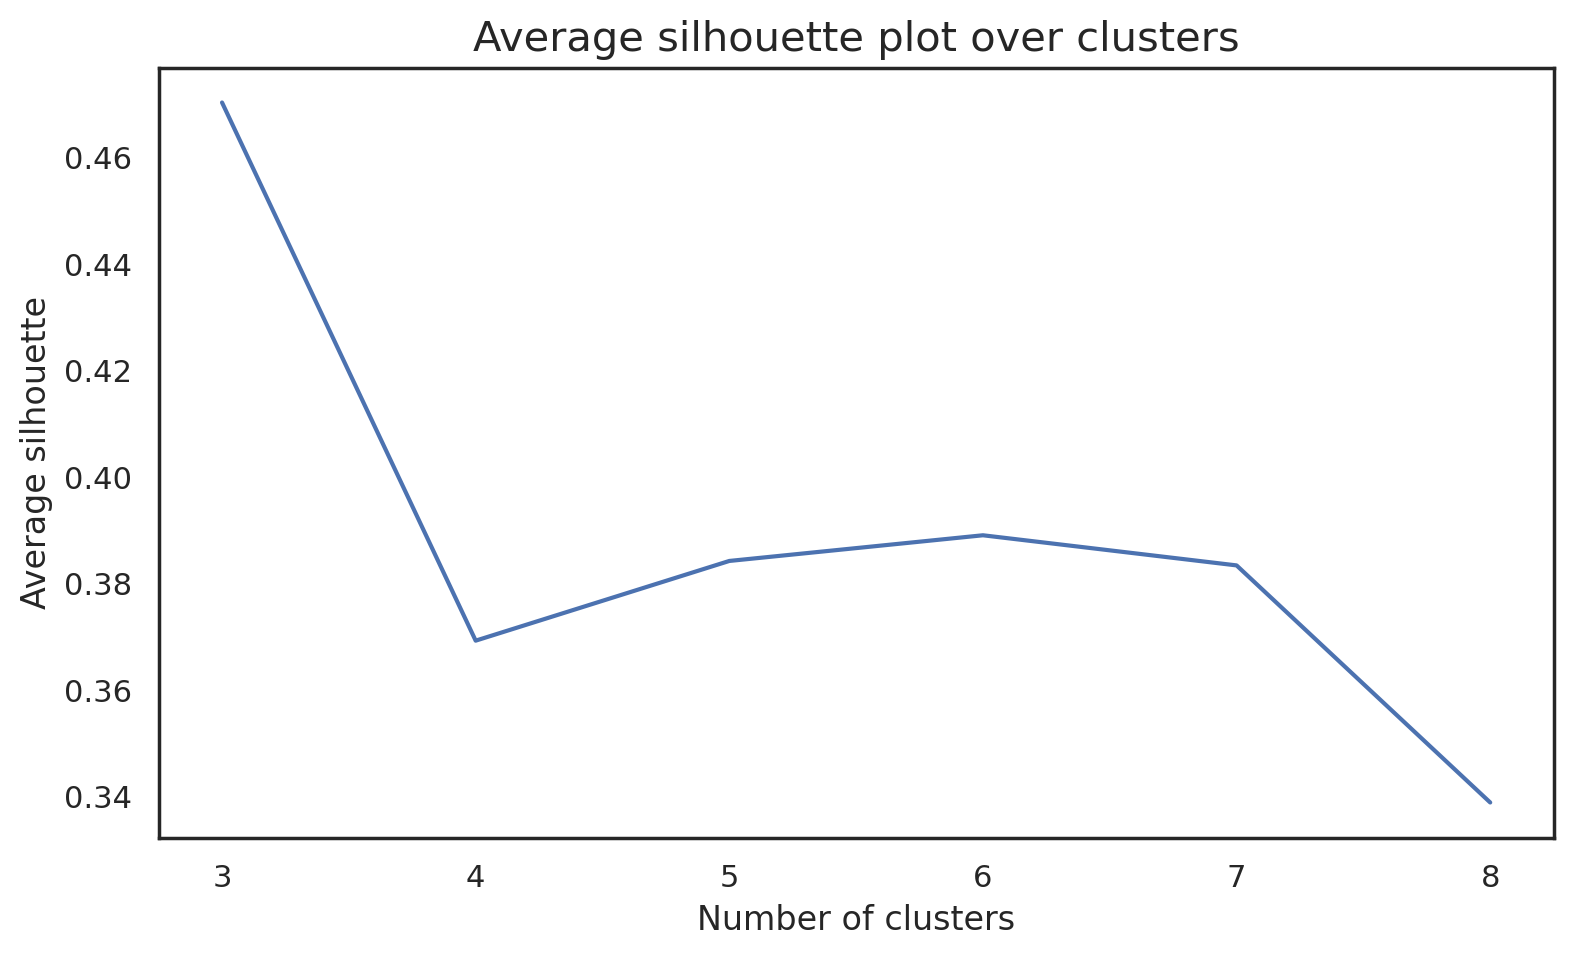

In [66]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))


#  Why range_clusters[1:] ? 
# Remember we skipped k=1 in the cell above

plt.plot(range(3, 9), ## Plot X-axis; 
         avg_silhouette)     ## Plot Y-axis

plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [67]:
n_clusters = 4

# Get the labels from hierarchical chosen clustering solution
cluster = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
hc_labels = cluster.fit_predict(spending_diversity_after_df)

# Calculate centroids based on these hierarchical clusters
centroids = []
for i in range(n_clusters):
    cluster_points = spending_diversity_after_df[hc_labels == i]  # Get points belonging to cluster i
    centroid = cluster_points.mean(axis=0)  # Calculate the mean of these points (centroid)
    centroids.append(centroid)

centroids = np.array(centroids)

In [68]:
# Hierarchical Clustreing centroids as seeds for Kmeans init
kmeans = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=20)  # n_init=1 since we are providing initial centroids
kmeans.fit(spending_diversity_after_df)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(spending_diversity_after_df, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3692473933780356


In [69]:
df_concat = pd.concat([
    spending_diversity_after_df, 
    pd.Series(hc_labels, name='labels', index=spending_diversity_after_df.index)
    ], 
    axis=1)
df_concat.groupby('labels').median()

,total_amt,n_cuisines,n_vendor,n_product
labels,,,,
0,1.075718,1.014873,1.325479,1.172866
1,-0.166992,0.306569,0.167712,-0.060467
2,3.795550,2.431482,3.641014,4.168103
3,-0.553111,-0.401736,-0.604133,-0.589038


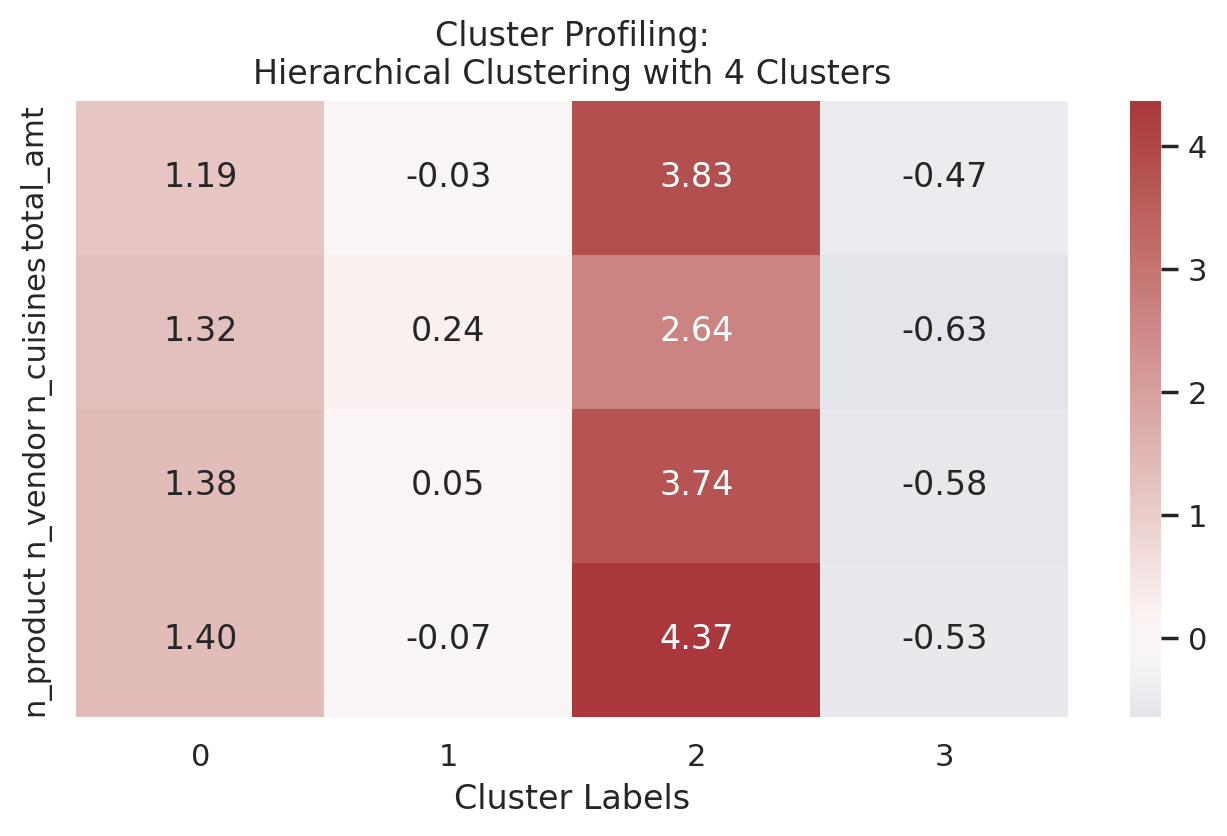

In [70]:
fig, ax = plt.subplots(figsize=(8,4))

hc_profile = df_concat.groupby('labels').mean().T

sns.heatmap(hc_profile,
            center=0, annot=True, cmap="vlag", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Cluster Labels")
ax.set_title(f"Cluster Profiling:\nHierarchical Clustering with {n_clusters} Clusters")
plt.show()

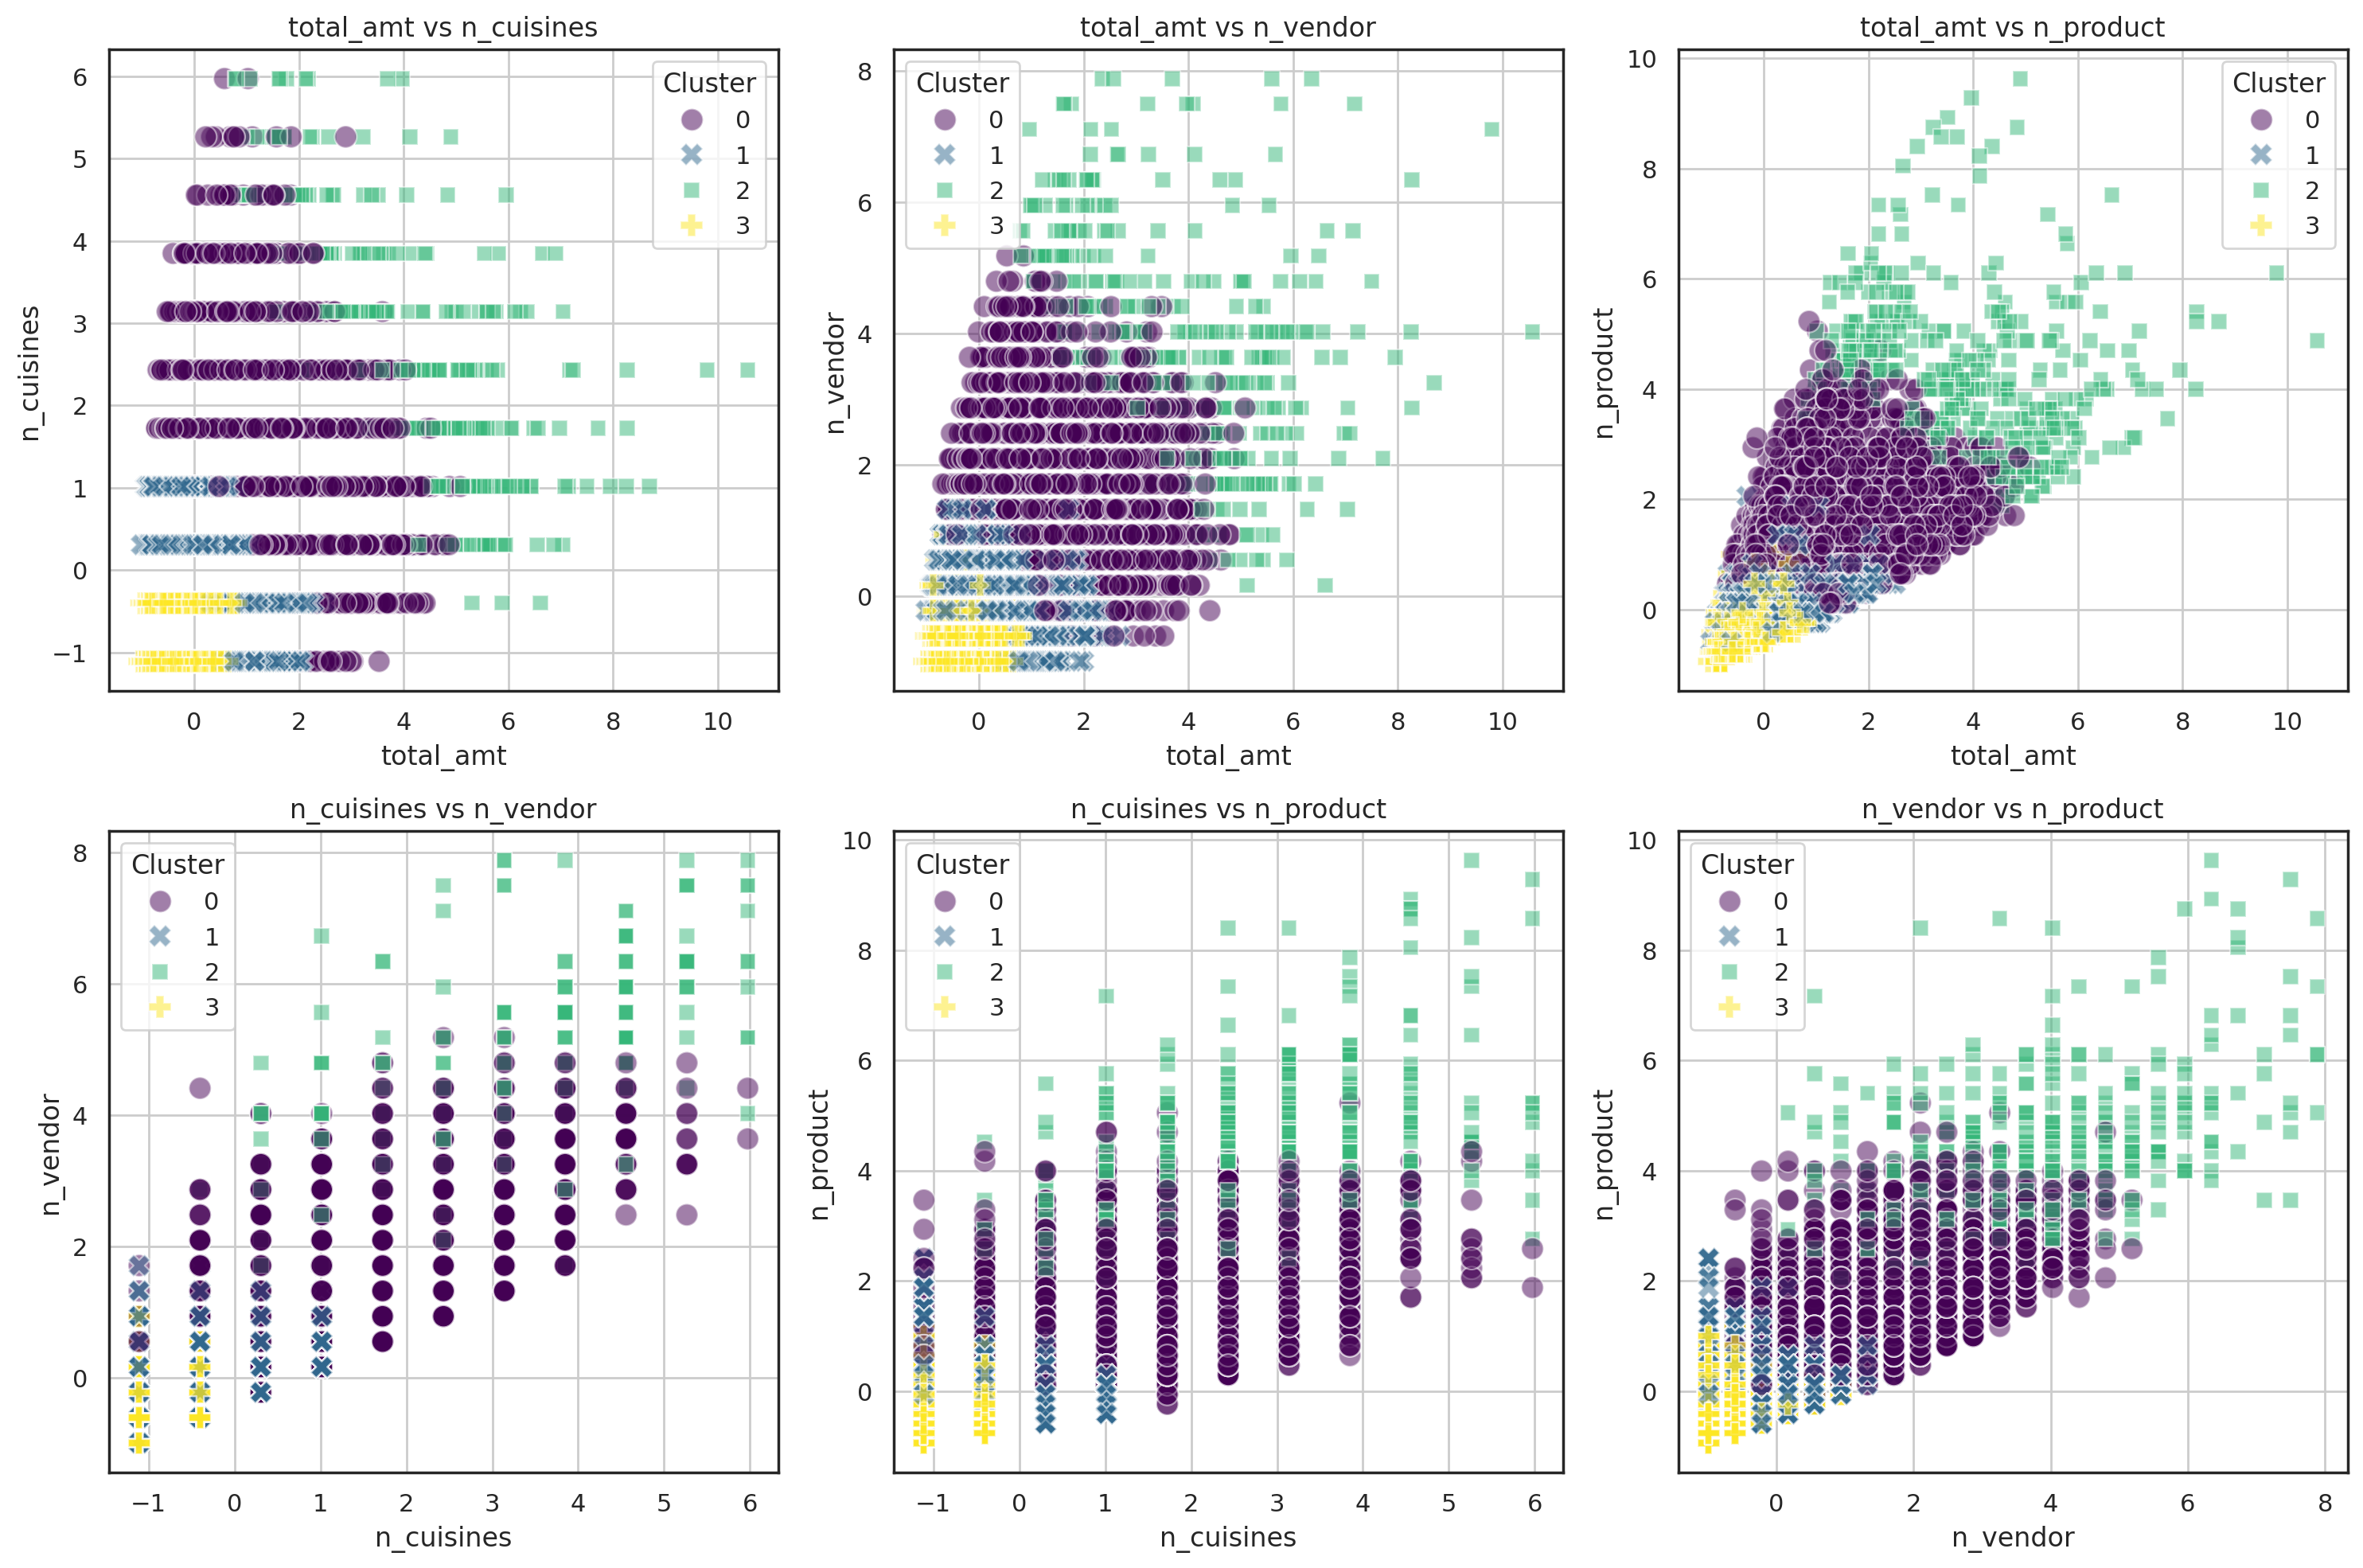

In [71]:
import itertools


combinations = list(itertools.combinations(df_concat.columns[:-1], 2))
n_combinations = len(combinations)

# Step 3: Set up subplots
n_cols = 3  # Number of columns in the grid
n_rows = (n_combinations + n_cols - 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

# Step 4: Plot each combination
for ax, (feature_x, feature_y) in zip(axes.flatten(), combinations):
    sns.scatterplot(
        data=df_concat,
        x=feature_x,
        y=feature_y,
        hue='labels',  # Cluster labels
        palette='viridis',
        style='labels',  # Optional: use style for labels too
        s=100,  # Point size
        alpha=0.5,  # Transparency
        ax=ax
    )
    ax.set_title(f"{feature_x} vs {feature_y}")
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)
    ax.legend(title="Cluster", loc='best')
    ax.grid(True)

# Remove any empty subplots
for i in range(n_combinations, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# Step 5: Adjust layout
plt.tight_layout()
plt.show()

### Profiling

In [72]:
sd_after_profiling = pd.merge(
    df_concat
    ,regulars[
        [col for col in regulars.columns if col.startswith('last_promo_')]
        +[col for col in regulars.columns if col.startswith('pay_method_')]
        +[col for col in regulars.columns if col.startswith('cust_city_')]
        +[col for col in regulars.columns if col.startswith('cust_region_')]
        +[col for col in regulars.columns if col.startswith('age_bucket_')]
    ]
    ,left_index=True
    ,right_index=True
    ,how='left'
)

In [73]:
profiling = {
    'Promotion': [col for col in sd_after_profiling.columns if col.startswith('last_promo_')]
    ,'Payment Method': [col for col in sd_after_profiling.columns if col.startswith('pay_method_')]
    ,'City': [col for col in sd_after_profiling.columns if col.startswith('cust_city_')]
    ,'Region': [col for col in sd_after_profiling.columns if col.startswith('cust_region_')]
    ,'Age': [col for col in sd_after_profiling.columns if col.startswith('age_bucket_')]
}

In [74]:
for profile, cols in profiling.items():
    cluster_profile = sd_after_profiling.groupby('labels')[cols].mean().reset_index()

    # Display cluster profiling
    print(f'Cluster Profiling Based on {profile}')
    display(cluster_profile)

Cluster Profiling Based on Promotion


,labels,last_promo_DELIVERY,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_NO_PROMO
0,0,0.108450,0.108450,0.128364,0.654736
1,1,0.125384,0.120561,0.145112,0.608943
2,2,0.099462,0.139785,0.118280,0.642473
3,3,0.171991,0.137357,0.142401,0.548252


Cluster Profiling Based on Payment Method


,labels,pay_method_CARD,pay_method_CASH,pay_method_DIGI
0,0,0.744080,0.108988,0.146932
1,1,0.718837,0.123922,0.157241
2,2,0.758065,0.123656,0.118280
3,3,0.671486,0.146184,0.182330


Cluster Profiling Based on City


,labels,cust_city_2.0,cust_city_4.0,cust_city_8.0
0,0,0.395587,0.280678,0.323735
1,1,0.378197,0.292562,0.329242
2,2,0.373656,0.333333,0.293011
3,3,0.309684,0.363231,0.327085


Cluster Profiling Based on Region


,labels,cust_region_2360.0,cust_region_2400.0,cust_region_4140.0,cust_region_4660.0,cust_region_8370.0,cust_region_8550.0,cust_region_8670.0
0,0,0.321851,0.073735,0.011033,0.269645,0.007804,0.000000,0.315931
1,1,0.308637,0.069560,0.014467,0.278094,0.010814,0.000438,0.317989
2,2,0.333333,0.040323,0.005376,0.327957,0.005376,0.000000,0.287634
3,3,0.255632,0.054052,0.035726,0.327505,0.015383,0.000252,0.311449


Cluster Profiling Based on Age


,labels,age_bucket_15-24,age_bucket_25-34,age_bucket_35-44,age_bucket_45-54,age_bucket_55-64,age_bucket_65+
0,0,0.379978,0.478202,0.113294,0.023950,0.003498,0.001076
1,1,0.382727,0.476692,0.110039,0.023089,0.005407,0.002046
2,2,0.405914,0.475806,0.091398,0.016129,0.008065,0.002688
3,3,0.390383,0.472932,0.108104,0.023621,0.003531,0.001429
